# CT processing for the new and improved data pipeline 

Steps involved:
1. Smoothing to remove/minimize overshoots, if any
2. Intensity standardization -- 2 options: Clipping or histogram standardization
3. Data augmentation transform
4. Rescaling intensities to [0,1] - Min-max normalization, with min and max intensity values taken from the volume

In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torchio
from torchio.transforms import HistogramStandardization

import sys
sys.path.append('../')
from datautils.visualization import NdimageVisualizer, display_image
from datautils.conversion import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
# Settings 
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFH_rs113_hecktor_nii"
standardization_method = 'clipping'  # 'clippling' or 'clipping+histogram'

## Comparing the difference in HU range between 2 CT volumes 

Min and Max HU: -3641.4973 2005.5107


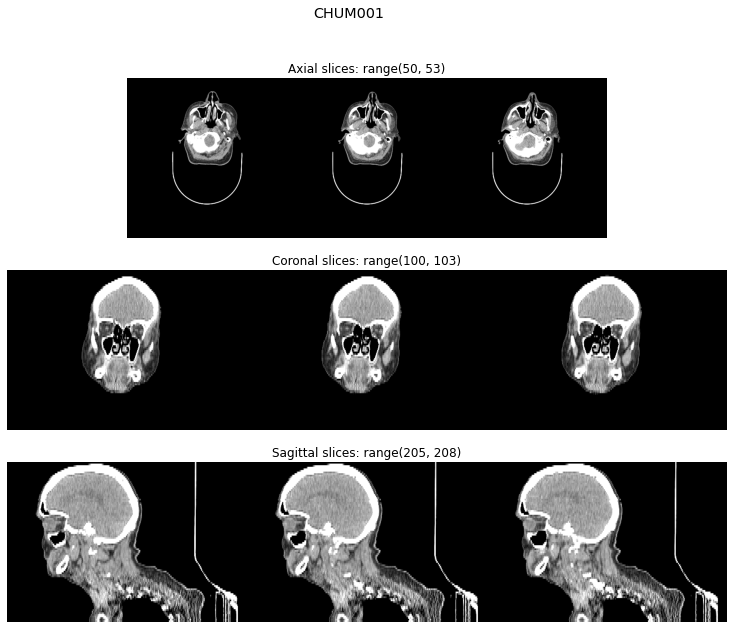

In [4]:
patient_1 = "CHUM001"
CT_sitk = sitk.ReadImage(f"{data_dir}/{patient_1}_ct.nii.gz") # Shape (W,H,D): 450x450x90 voxels
CT_np = sitk2np(CT_sitk, keep_whd_ordering=True)

print("Min and Max HU:", CT_np.min(), CT_np.max())

display_image(CT_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window={'level':0, 'width':300},
               title=patient_1, cmap='gray')

Min and Max HU: -16757.941 30057.14


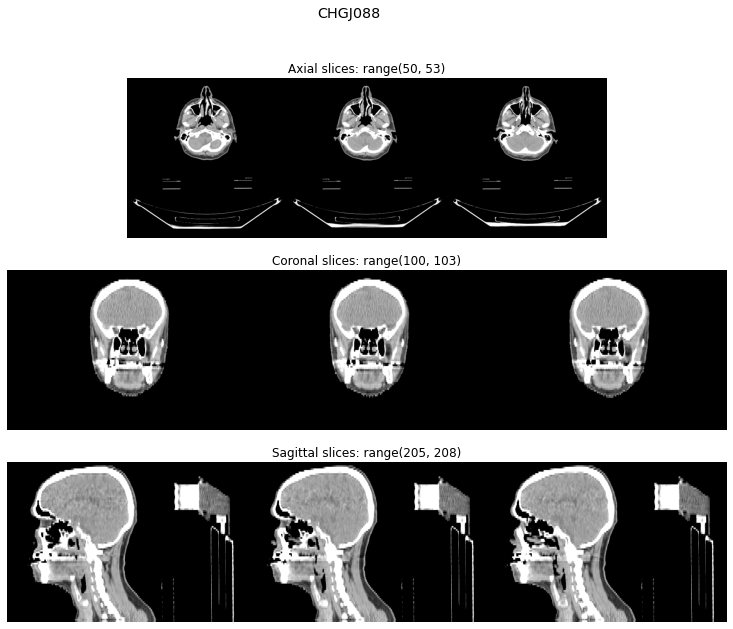

In [6]:
patient_2 = "CHGJ088"
CT2_sitk = sitk.ReadImage(f"{data_dir}/{patient_2}_ct.nii.gz") # Shape (W,H,D): 450x450x90 voxels
CT2_np = sitk2np(CT2_sitk, keep_whd_ordering=True)

print("Min and Max HU:", CT2_np.min(), CT2_np.max())

display_image(CT2_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window={'level':0, 'width':300},
               title=patient_2, cmap='gray')

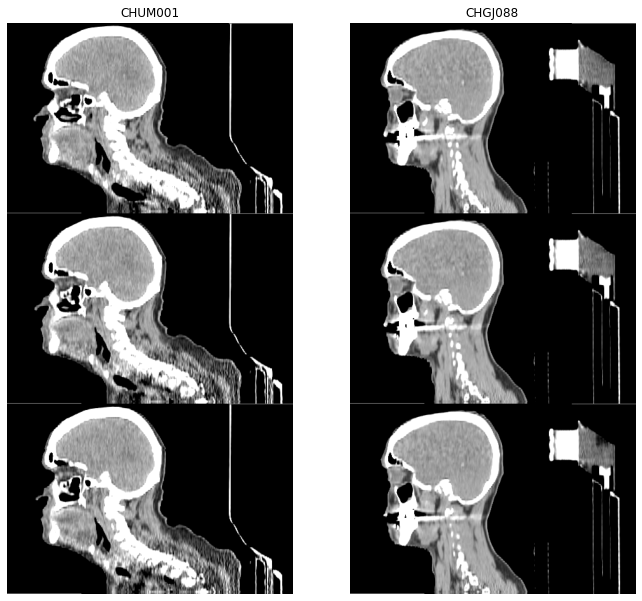

In [7]:
viz = NdimageVisualizer()
viz.multi_image_strips([CT_np, CT2_np],
                          modalities=['CT'] * 2,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=[patient_1, patient_2])

## 1 Smoothing

In [29]:
t1 = time.time()
sigma = [1.0, 1.0, 1.0/3] # In format (W,H,D), Physical sigma of 2mm adjusted according to voxel spacing
CT_smooth_np = scipy.ndimage.gaussian_filter(CT_np, sigma=sigma)
time_diff = time.time() - t1

#print(f"Time taken for filtering: {time_diff:.2f}s")

print("Min and Max HU:", CT_smooth_np.min(), CT_smooth_np.max())

Min and Max HU: -3024.0251 1827.3124


## 2 Standardizing the Intensities

In [30]:
CT_std_np = CT_smooth_np.copy()

if standardization_method == 'clipping':
    clipping_range = [-150,150] # HU
    CT_std_np[CT_smooth_np < clipping_range[0]] = clipping_range[0]
    CT_std_np[CT_smooth_np > clipping_range[1]] = clipping_range[1]

elif standardization_method == 'clipping+histogram':
    # TODO
    pass

print("Min and Max HU:", CT_std_np.min(), CT_std_np.max())

Min and Max HU: -150.0 150.0


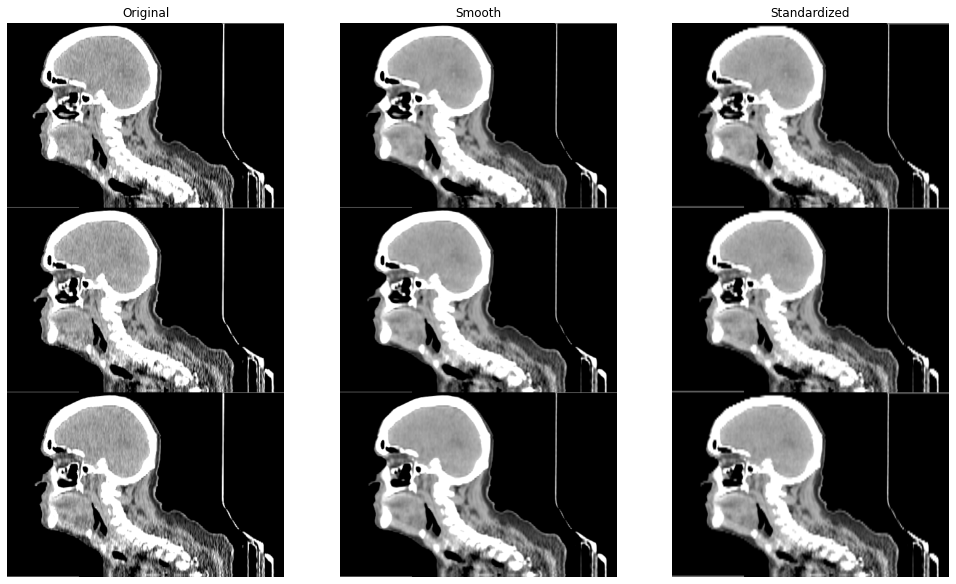

In [31]:
viz.multi_image_strips([CT_np, CT_smooth_np, CT_std_np],
                          modalities=['CT'] * 3,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["Original", "Smooth", "Standardized"])

## 3 Data Augmentation

### 3.2 Random rotation

In [22]:
# Affine matrix that encodes the spacing (1,1,3) as 3x scaling/zoom along z-axis
affine_matrix = np.array([[1,0,0,0],
                          [0,1,0,0],
                          [0,0,3,0],
                          [0,0,0,1]])

CT_tio = torchio.Image(tensor=np.expand_dims(CT_std_np,axis=0), type=torchio.INTENSITY, affine=affine_matrix)
print("Spacing:", PET_tio.spacing) # Check the spacing

subject = torchio.Subject({'CT':CT_tio})

(1.0, 1.0, 3.0)


In [23]:
rotation_transform = torchio.RandomAffine(scales=(1,1), degrees=(-10,10), translation=(0,0))
CT_rot_np = rotation_transform(subject).get_images_dict()['CT'].numpy().squeeze()

### 3.3 Random scaling (no change in image size)

In [24]:
scaling_transform = torchio.RandomAffine(scales=(0.85,1.15), degrees=(0,0), translation=(0,0))
CT_scl_np = scaling_transform(subject).get_images_dict()['CT'].numpy().squeeze()

### 3.4 Elastic distortion

In [27]:
elastic_transform = torchio.RandomElasticDeformation(num_control_points=(7,7,7), max_displacement=(20,20,20), locked_borders=2)
CT_elastic_np = elastic_transform(subject).get_images_dict()['CT'].numpy().squeeze()

Min and max HU: -150.0 150.0
Min and max HU: -150.0 150.0
Min and max HU: -150.0 150.0
Min and max HU: -150.0 150.0


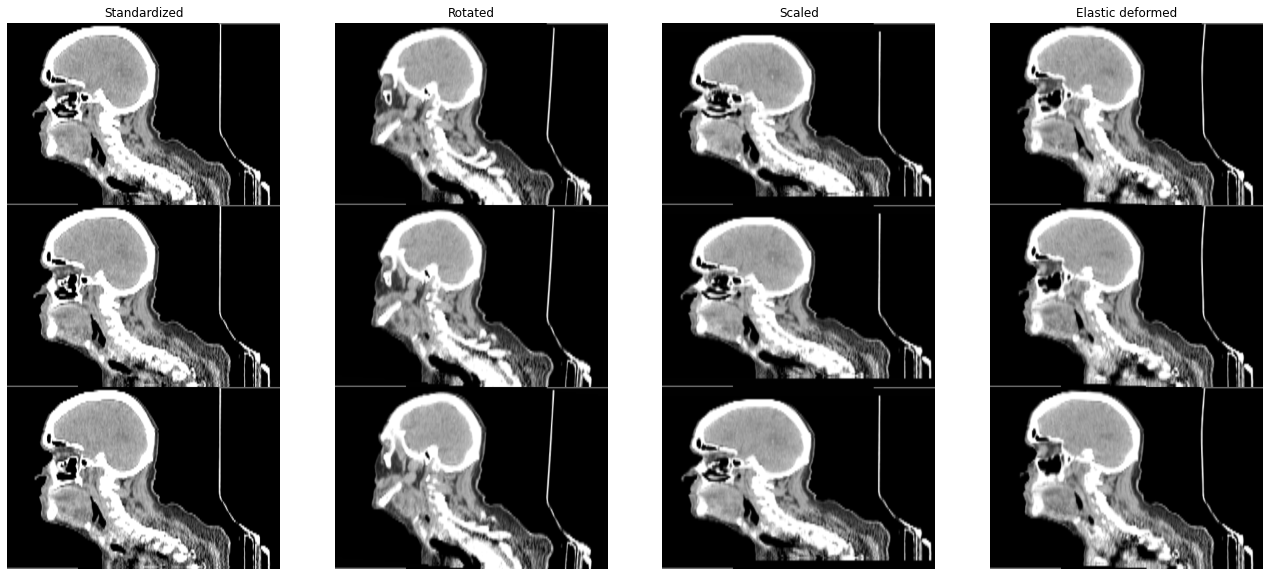

In [28]:
print("Min and max HU:", CT_std_np.min(), CT_std_np.max())
print("Min and max HU:", CT_rot_np.min(), CT_rot_np.max())
print("Min and max HU:", CT_scl_np.min(), CT_scl_np.max())
print("Min and max HU:", CT_elastic_np.min(), CT_elastic_np.max())

viz.multi_image_strips([CT_std_np, CT_rot_np, CT_scl_np, CT_elastic_np],
                          modalities=['CT'] * 4,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["Standardized", "Rotated", "Scaled", "Elastic deformed"])

## 4 Rescaling intensities to [0,1]

In [ ]:
CT_norm_np = (CT_std_np - CT_std_np.min()) / (CT_std_np.max() - CT_std_np.min())